# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [57]:
#importing libraries
import pandas as pd
import numpy as np
import math
import lightgbm as ltb
import lightgbm as lgb

from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split, TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from plotly.figure_factory import create_distplot
import plotly.figure_factory as ff
from plotly.figure_factory import create_scatterplotmatrix

import time

In [28]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [29]:
df.sample(10)

,num_orders
datetime,
2018-06-25 14:20:00,11
2018-04-22 02:40:00,18
2018-06-13 03:20:00,8
2018-03-14 12:10:00,6
2018-07-24 14:40:00,16
2018-07-11 13:40:00,15
2018-08-13 05:30:00,11
2018-06-27 22:00:00,23
2018-05-22 07:20:00,7


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [31]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [32]:
df.index.is_monotonic

True

In [33]:
df = df.resample('1H').sum()

In [34]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [35]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


### Conclusion

We have a dataset with 2 columns and 26496 rows. I checked first the format of datetime columns and converted it from object to datetime type, also made this column as index. We don't have any missing values in dataset, our underlying data in the given Index object is monotonically increasing. We have an information about orders of period since March, 2018 to August, 2018. I resampled it and now have a summation of all orders for every hour.
So we are ready to analize the data now.

## Analysis

In [36]:
fig = px.line(df, y='num_orders', title="Number of orders of all time")
fig.show()

As we can see in the August the number of orders is increasing. Maybe it can be connect with finishing of vacation season. Let's take a look on the picture if we will use a rolling mean method for 24 hours.

In [37]:
df24 = df.rolling(24).mean()

In [38]:
fig = px.line(df24, y='num_orders', title="Number of orders with rolling mean method")
fig.show()

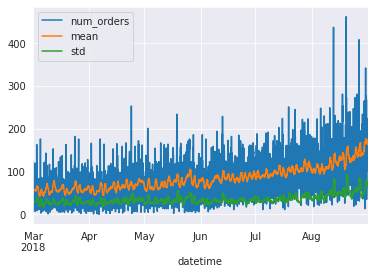

In [39]:
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df.plot()
plt.show()

Ok, now we can see more clearly that the number of orders increases since March.

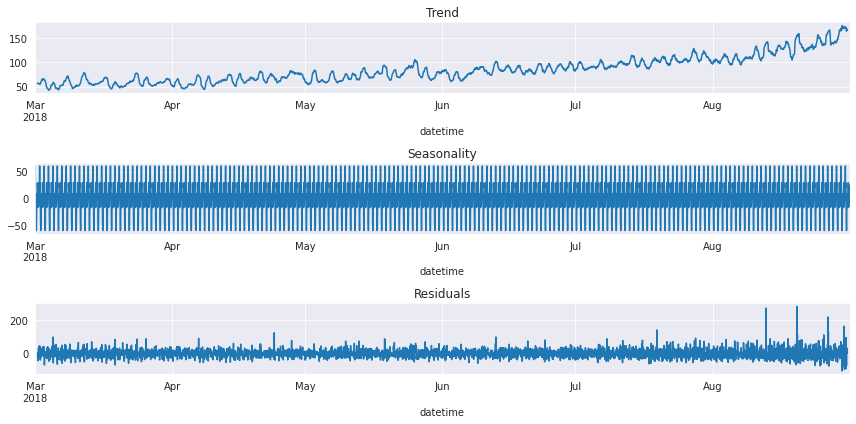

In [40]:
#check for trend and seasonality
decomposed = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(12, 6))

#plot a chart for trend
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

#plot a chart for seasonality
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

#plot a chart for residuals 
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

As we saw before we have a trend: increasing the number of orders during the all period, especiall in August. From seasonality it is hard to say anything, need to modify the graph a little bit to zoom it and see what do we have.

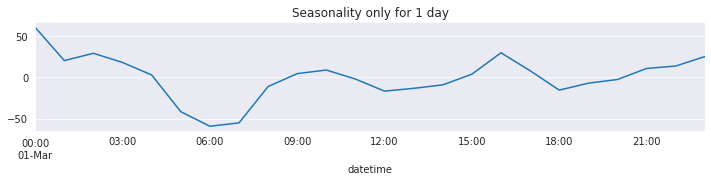

In [41]:
#seasonality chart for only 1 day
decomposed.seasonal[:24].plot(figsize=(12,2))
plt.title('Seasonality only for 1 day')
plt.show()

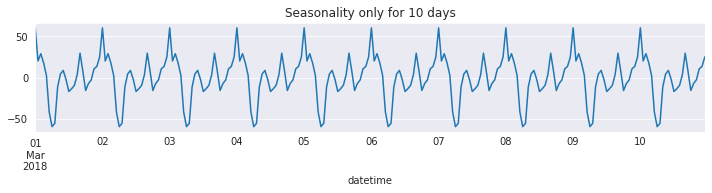

In [42]:
#seasonality chart for only 10 days
decomposed.seasonal[:240].plot(figsize=(12,2))
plt.title('Seasonality only for 10 days')
plt.show()

Ok, now we see that we have a pick of ordersin the night time which can be explained that we there is no a publical transport that time. 

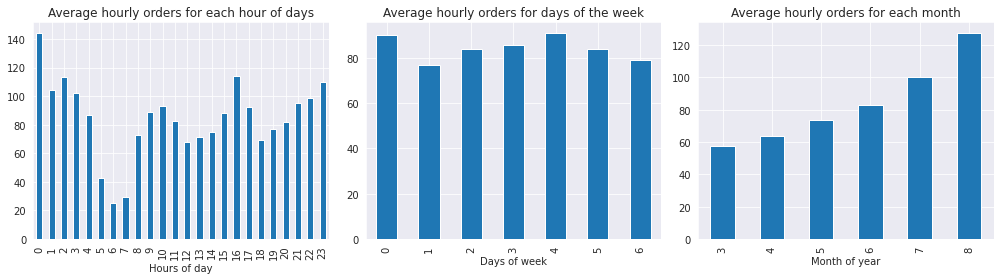

In [43]:
#group the data by hours of days, and get average orders at each hour of day
plt.figure(figsize=(14, 4))
plt.subplot(131)
df.groupby(df.index.hour)['num_orders'].mean().plot(kind='bar', ax=plt.gca())
plt.title('Average hourly orders for each hour of days')
plt.xlabel('Hours of day')


#group the data by days of week and get average orders at each day
plt.subplot(132)
df.groupby(df.index.dayofweek)['num_orders'].mean().plot(kind='bar', ax=plt.gca())
plt.title('Average hourly orders for days of the week')
plt.xlabel('Days of week')

#group the data by months and get average for each month
plt.subplot(133)
df.groupby(df.index.month)['num_orders'].mean().plot(kind='bar', ax=plt.gca())
plt.title('Average hourly orders for each month')
plt.xlabel('Month of year')


plt.tight_layout()
plt.show()

### Conclusion

After observation of the data we have, we can say that there is a clearly trend, the number of orders increases during the all period. If we will take a look at the weekly number of orders in average we can see that there is no big difference between days of week, but on Monday and Friday there are a little more orders which can be explained by starting an activity on Monday. On Friday it can be because a lot of people went for a rest after the work week. On the daily graph we can see seasonality. After observation a graph for 1 day and for 10 days we can say that we have a pick of orders in the night time(midnight) which can be connected with unavailable public transport.

## Training

In this section we will check different algorithms with tuning hyperparameters, if any. Following algorithms will be check:

  - Linear regression
  - Random Forest
  - LightGBM
  - Catboost
  
Before that, let's prepare our features.  We have observed that the month and hour of the day have a great impact on the number of orders. Therefore, we will create month and hour columns. Then we have seen that there is daily seasonality, hence we will choose lag for 24 hours. And setting rolling mean values to 24 will again give use more stationary mean, std.
  

In [44]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [45]:
make_features(df, 2, 24)
df.head(2)

,num_orders,mean,std,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,124.0,NaN,NaN


Need to split the data and train models:

In [46]:
train_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

In [47]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

**Linear Regression**

In [49]:
%%time
lr = LinearRegression() 
lr.fit(features_train, target_train) 
predicted_train = lr.predict(features_train) 
predicted_valid = lr.predict(features_valid) 

# RMSE
print("RMSE of train set:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE of valid set ", mean_squared_error(target_valid, predicted_valid) ** 0.5)
        

RMSE of train set: 25.88839496312845
RMSE of valid set  35.24956417968779
CPU times: user 18.7 ms, sys: 15.9 ms, total: 34.6 ms
Wall time: 10.6 ms


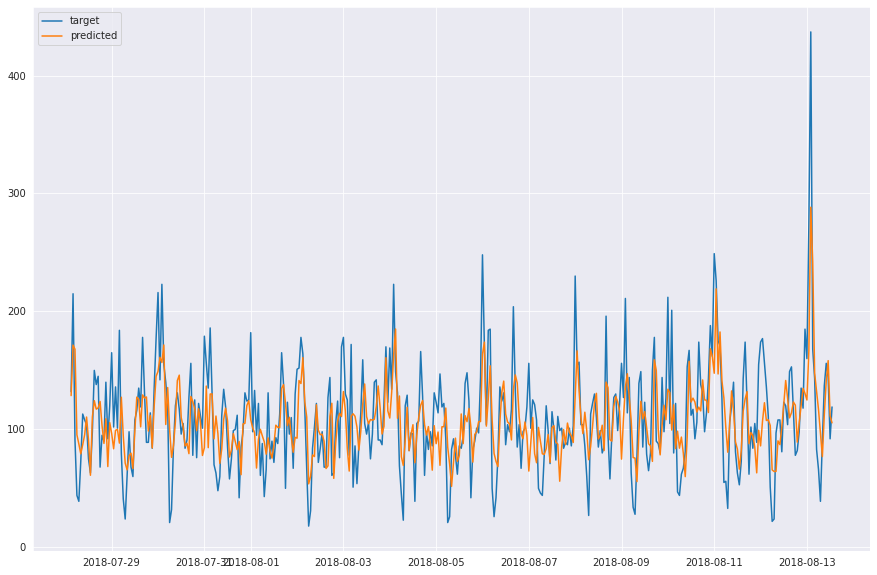

In [50]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

**Random Forest**

In [51]:
%%time
rm = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42) 
rm.fit(features_train, target_train) 
predicted_train = rm.predict(features_train) 
predicted_valid = rm.predict(features_valid) 

# RMSE
print("RMSE of train set:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE of valid set ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE of train set: 20.927326408838027
RMSE of valid set  32.94073541193245
CPU times: user 626 ms, sys: 3.23 ms, total: 630 ms
Wall time: 628 ms


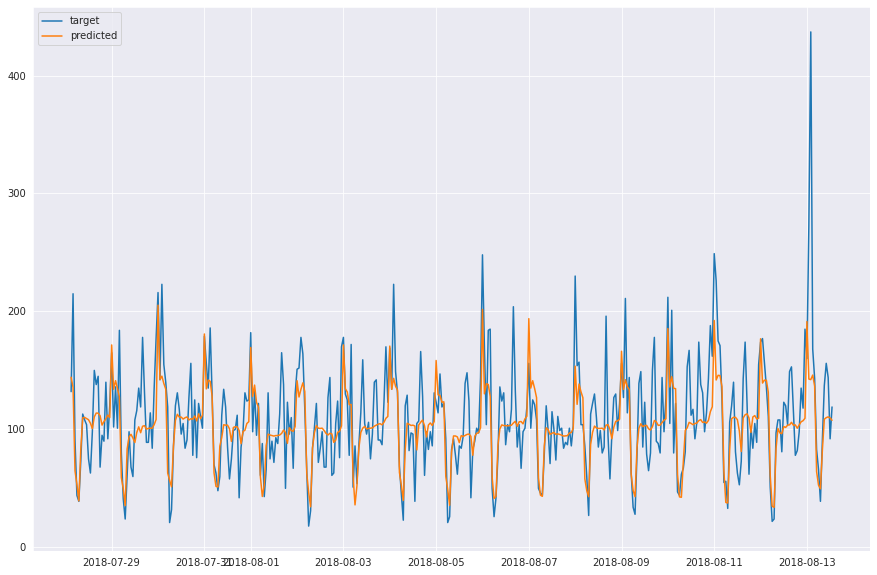

In [52]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

**Catboost**

In [72]:
%%time
cb = CatBoostRegressor(n_estimators=600,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3, 
                       task_type='CPU',
                       random_state=42, 
                       verbose=False)
cb.fit(features_train, target_train) 
predicted_train = cb.predict(features_train)
predicted_valid = cb.predict(features_valid) 

# RMSE
print("RMSE of train set:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE of valid set ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE of train set: 9.583972602258234
RMSE of valid set  27.706192946094003
CPU times: user 457 ms, sys: 68.7 ms, total: 526 ms
Wall time: 899 ms


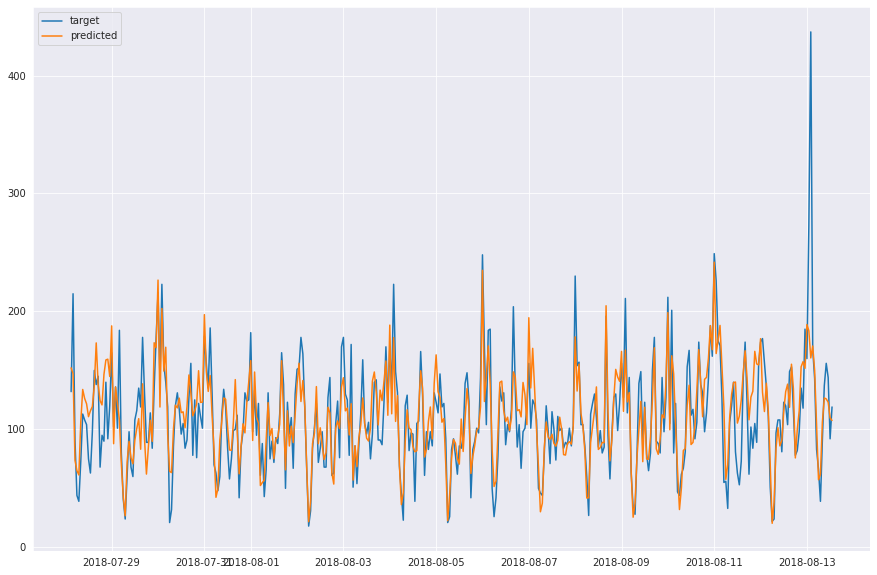

In [73]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

**LightGBM**

In [58]:
%%time
lgb = lgb.LGBMRegressor(n_estimators=200, 
                          learning_rate=0.1, 
                          num_leaves=10, 
                          max_depth=20, 
                          random_state=42) 
lgb.fit(features_train, target_train) 
predicted_train = lgb.predict(features_train) 
predicted_valid = lgb.predict(features_valid) 

# RMSE
print("RMSE of train set:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE of valid set ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE of train set: 14.070575112596266
RMSE of valid set  28.096099478381795
CPU times: user 3min 20s, sys: 1.68 s, total: 3min 22s
Wall time: 3min 24s


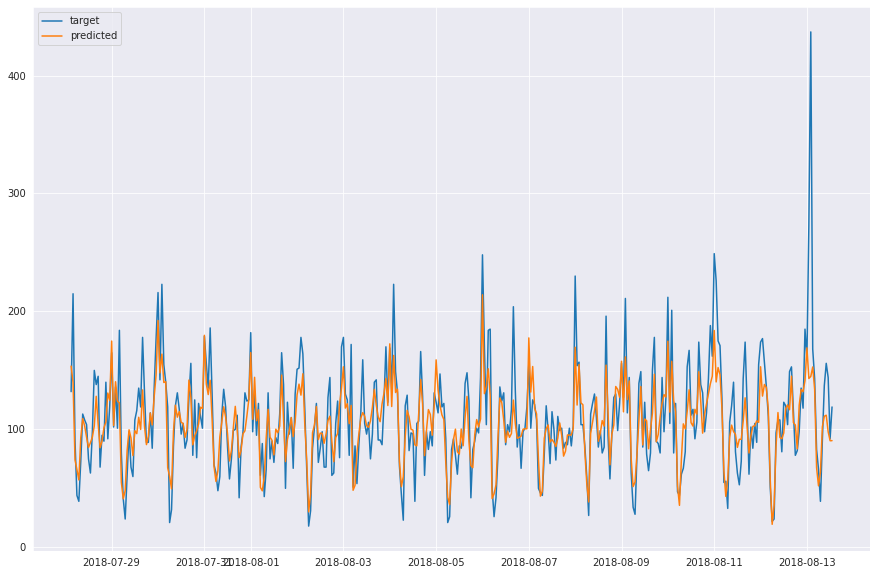

In [59]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

In [74]:
res = {
     'Model': ['Linear Regression', 'Random Forest', 'Catboost', 'LGBM'],
     'RMSE': ['35.25', '32.94', '27.71', '28.10'],
 }
results = pd.DataFrame(data=res)

In [75]:
results

,Model,RMSE
0,Linear Regression,35.25
1,Random Forest,32.94
2,Catboost,27.71
3,LGBM,28.10


### Conclusion

We trained a different models: Linear Regression, Random Forest, LGBM and Catboost. As we can see from the table above the best RMSE scoring have: Catboost(28.04) and LGBM(28.10). Let's check them on the test set.

## Testing

In [71]:
%%time
model = CatBoostRegressor(n_estimators=600,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3, 
                       task_type='CPU',
                       random_state=42, 
                       verbose=False)
model.fit(features_train, target_train) 
predicted_test = model.predict(features_test) 


print("RMSE of test set:", mean_squared_error(target_test, predicted_test) ** 0.5)

RMSE of test set: 44.826040216335954
CPU times: user 485 ms, sys: 42.8 ms, total: 528 ms
Wall time: 884 ms


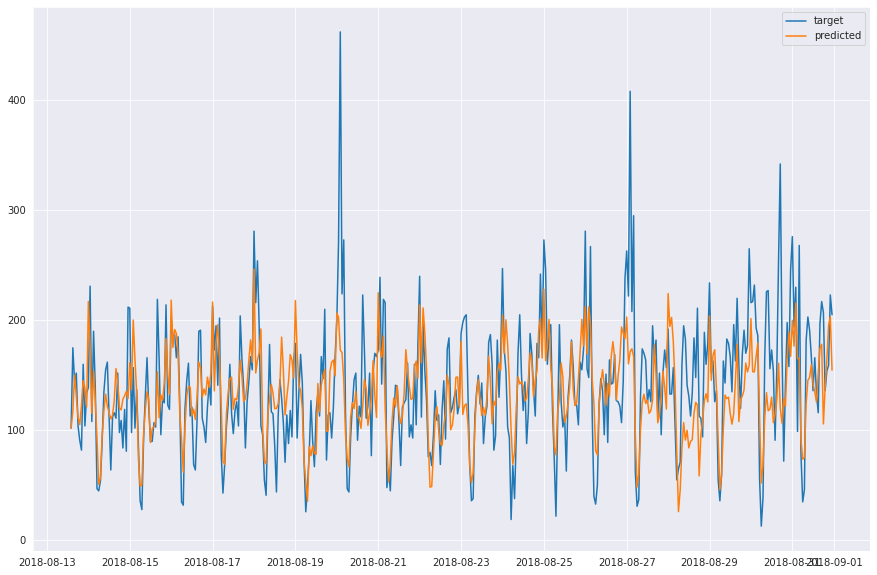

In [76]:
a = target_test.tolist()
b = predicted_test.tolist()
c = target_test.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()


In [78]:
%%time
model = LGBMRegressor(n_estimators=200, 
                          learning_rate=0.1, 
                          num_leaves=10, 
                          max_depth=20, 
                          random_state=42) 
model.fit(features_train, target_train) 
predicted_test = lgb.predict(features_test) 
 

# RMSE
print("RMSE of test set:", mean_squared_error(target_test, predicted_test) ** 0.5)

RMSE of test set: 53.209384423155186
CPU times: user 10.3 s, sys: 65.3 ms, total: 10.4 s
Wall time: 10.4 s


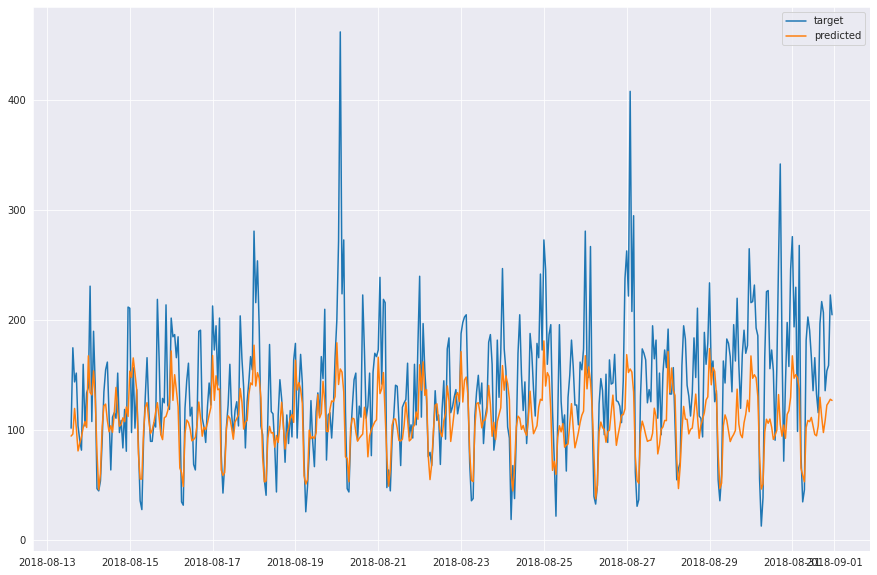

In [79]:
a = target_test.tolist()
b = predicted_test.tolist()
c = target_test.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()


In [80]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train,target_train)
dummy_predict = dummy_regr.predict(features_test)
print('RMSE', mean_squared_error(target_test, dummy_predict)**0.5)

RMSE 87.20279462388325


# Conclusion

We have a dataset with 2 columns and 26496 rows. I checked first the format of datetime columns and converted it from object to datetime type, also made this column as index. We don't have any missing values in dataset, our underlying data in the given Index object is monotonically increasing. We have an information about orders of period since March, 2018 to August, 2018. I resampled it and now have a summation of all orders for every hour. After observation of the data we have, we can say that there is a clearly trend, the number of orders increases during the all period. If we will take a look at the weekly number of orders in average we can see that there is no big difference between days of week, but on Monday and Friday there are a little more orders which can be explained by starting an activity on Monday. On Friday it can be because a lot of people went for a rest after the work week. On the daily graph we can see seasonality. After observation a graph for 1 day and for 10 days we can say that we have a pick of orders in the night time(midnight) which can be connected with unavailable public transport. 
We trained a different models: Linear Regression, Random Forest, LGBM and Carboost. As we can see from the table above the best RMSE scoring have: Catboost(28.04) and LGBM(28.10).
it has RMSE less then 48.